# modes_at_surface
re-build HKE (and SSE, or whatever field) at the surface, for comparison with the total field

N.B.: this is a bit memory demanding: take not less than 8GB RAM.

In [7]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from netCDF4 import Dataset
import scipy.signal as sig
import time


In [5]:
krypton = "/data0/project/vortex/lahaye/"
simul = "luckym2"
fnamode = krypton+"{0}_modemap/{0}_modemap.nc".format(simul)
gname = krypton+"lucky_corgrd.nc"
fnamsur = krypton+"DIAG/{}_HKE_iz79.nc".format(simul)

rho0 = 1025.
grav = 9.81
M2 = 1/12.42
M1 = M2/2.

In [3]:
# load modal reconstruction of fields

imod = "all"

nc = Dataset(fnamode, "r")
xi = nc.variables['xi_rho'][:]
eta = nc.variables['eta_rho'][:]
otime = nc.variables['ocean_time'][:]
Nt, Nx, Ny = otime.size, xi.size, eta.size

tmes, tmeb = time.clock(), time.time()
if imod == "all":
    imod = np.arange(nc.dimensions["mode"].size)
if isinstance(imod,int):
    pmod = nc.variables['p_modes'][imod:imod+1,-1,:,:]
    uu = nc.variables['u_amp'][:,imod,:,:] * pmod
    vv = nc.variables['v_amp'][:,imod,:,:] * pmod
    zeta = nc.variables['p_amp'][:,imod,:,:]/grav * pmod
else:
    pmod = nc.variables['p_modes'][imod,-1,:,:]
    uu = np.zeros((Nx, Ny, Nt))
    vv, zeta = uu.copy(), uu.copy()
    for it in range(Nt):
        uu[:,:,it] = np.nansum(nc.variables['u_amp'][it,imod,:,:] * pmod, axis=0).T
        vv[:,:,it] = np.nansum(nc.variables['v_amp'][it,imod,:,:] * pmod, axis=0).T
        zeta[:,:,it] = np.nansum(nc.variables['p_amp'][it,imod,:,:]/grav * pmod, axis=0).T
        if ((it+1)%10)==0:
            print(it, end='... ')
nc.close()
print('')

print("finished loading fields: timing:",time.clock()-tmes, time.time()-tmeb)


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


9... 19... 29... 39... 49... 59... 69... 79... 89... 99... 109... 119... 129... 139... 149... 159... 169... 179... 189... 199... 209... 219... 229... 239... 249... 259... 269... 279... 289... 299... 309... 319... 329... 339... 349... 359... 369... 379... 389... 399... 409... 419... 429... 439... 449... 459... 469... 479... 489... 499... 509... 519... 529... 539... 549... 559... 569... 579... 589... 599... 609... 619... 629... 639... 649... 659... 669... 679... 689... 699... 709... 719... 
finished loading fields: timing: 45.826081 572.0125534534454


In [5]:
# load grid & topo
nc = Dataset(gname, "r")
topo = nc.variables['h'][eta,:][:,xi]
lon = nc.variables['lon_rho'][eta,:][:,xi]
lat = nc.variables['lat_rho'][eta,:][:,xi]
nc.close()

In [6]:
# compute modal spectra
dt = np.diff(otime[:2])
Lwin = 7
nwindow = int(Lwin*24./dt)

fcut = 5/12.42*24
freq, _ = sig.welch(otime, fs=24./dt, nperseg=nwindow)
freq = freq[freq<=fcut]
Nf = len(freq)

psd, psz = np.zeros((Ny,Nx,Nf)), np.zeros((Ny,Nx,Nf))
for iy in range(Ny):
    _, prov = sig.welch(uu[iy,:,:], fs=24./dt, nperseg=nwindow)
    psd[iy,:,:] = prov[:,:Nf]/2.
    _, prov = sig.welch(vv[iy,:,:], fs=24./dt, nperseg=nwindow)
    psd[iy,:,:] += prov[:,:Nf]/2.
    _, prov = sig.welch(zeta[iy,:,:], fs=24./dt, nperseg=nwindow)
    psz[iy,:,:] = prov[:,:Nf]


5


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


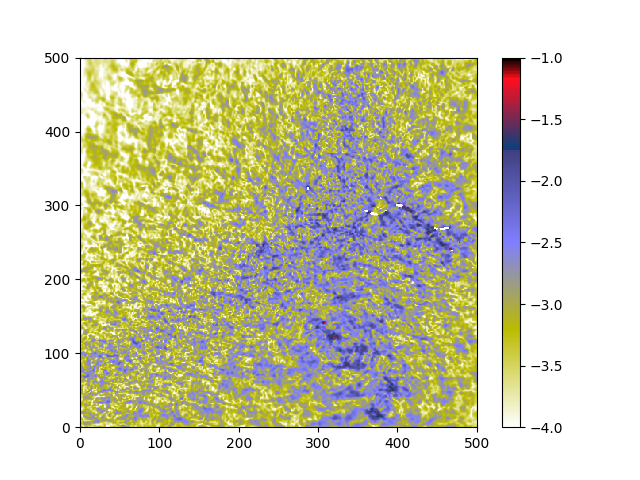

In [34]:
# compute energy in spectral band and plotls

fwdt = 1.2
ff = M2*24
inds, = np.where( (freq>=ff/fwdt) & (freq<=ff*fwdt))
print(len(inds))

toplot = np.trapz(psd[:,:,inds], freq[inds], axis=-1)
vmin, vmax = -4, -1

plt.pcolormesh(np.log10(toplot.T), cmap="gist_stern_r" , vmin=vmin, vmax=vmax); plt.colorbar()

In [10]:
# compute filtered time series
bb, aa = sig.butter(4, ff/24*2*dt*np.array([1./fwdt,fwdt]), btype='band')
bl, al = sig.butter(4, ff/24*2/1.33, btype='low')
nst = 4

eklf = np.zeros((Nx, Ny, Nt//nst))
for iy in range(Ny):
    prov = sig.filtfilt(bb, aa, uu[iy,:,:]-uu.mean(), axis=-1, method='gust')
    prav = sig.filtfilt(bb, aa, vv[iy,:,:]-vv.mean(), axis=-1, method='gust')
    eklf[iy,:,:] = sig.filtfilt(bl, al, 0.5*(prov**2+prav**2), axis=-1, method="gust")[:,::nst]
    if (iy+1)%100 == 0:
        print(iy, end='... ')

719... 719... 719... 719... 719... 

<IPython.core.display.Javascript object>


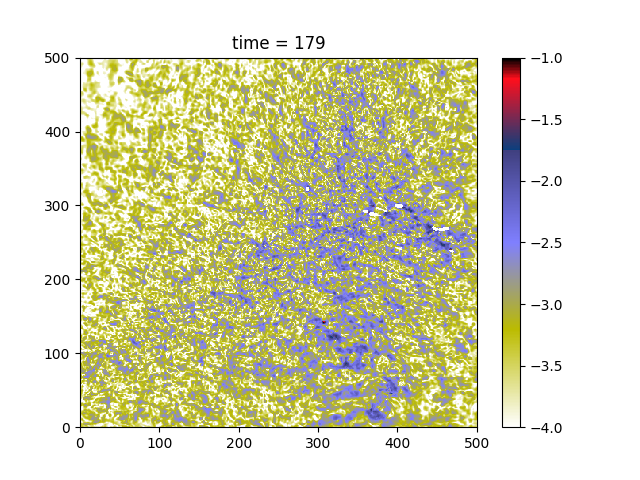

In [30]:
# animate field

tts = np.arange(eklf.shape[-1])

toplot = np.log10(eklf.T)
cmap = "gist_stern_r" #"seismic" #

vamp = np.nanstd(toplot[-1,:,:])
vmin, vmax = -4, -1


fig = plt.figure()
ax = plt.gca()
hp = ax.pcolormesh(np.zeros((Ny,Nx)), cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar(hp, ax=ax)
    
def fanim(it):
    hp.set_array(toplot[it,:,:].ravel())
    ax.set_title('time = {:03d}'.format(it))

ani = FuncAnimation(fig, fanim, frames=tts, interval=100, repeat=False)

plt.show()

In [28]:
# try reading from surface-modal

# load modal energy (vertical integral)
imod = slice(1,10)

nc = Dataset(fnamode.replace('modemap.nc','modal_surf_spectra.nc'),'r')

times = nc.variables['time'][:]
nt = len(times)
modes = nc.variables['mode'][:]
xi = nc.variables['xi_rho'][:]
eta = nc.variables['eta_rho'][:]
lon = nc.variables['lon_rho'][:]
lat = nc.variables['lat_rho'][:]
if whatfield == "HKE":
    data = np.nansum(nc.variables['ek_lf'][nt//2,imod,:,:], axis=0)
else:
    raise ValueError('{} not implemented yet'.format(whatfield))
ncgrd = Dataset(grid_file,'r')
topo = ncgrd.variables['h'][:,xi][eta,:]
dx = np.mean(1./ncgrd.variables['pm'][:,xi][eta,:])
dy = np.mean(1./ncgrd.variables['pn'][:,xi][eta,:])
ncgrd.close()
topo.shape

0.20001993850038813

In [42]:
fnamode.replace('modemap.nc','modal_surf_spectra.nc')

'/data0/project/vortex/lahaye/luckym2_modemap/luckym2_modal_surf_spectra.nc'